[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AleksUv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AleksUv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AleksUv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


LDA Model:


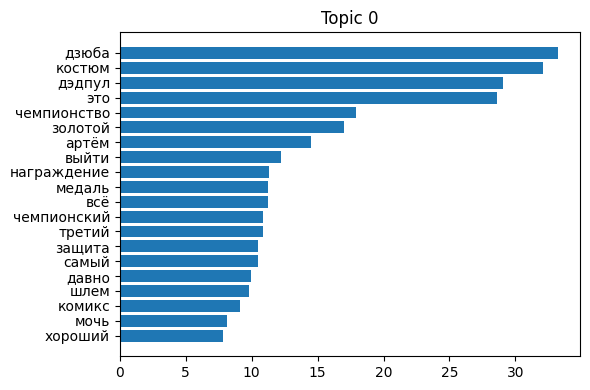

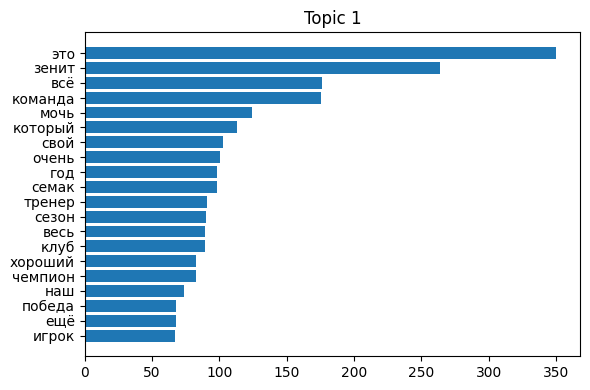

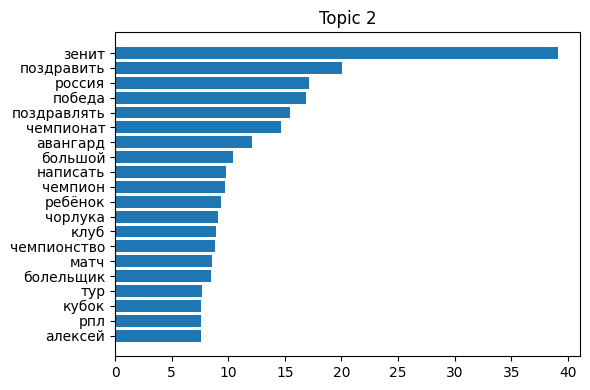

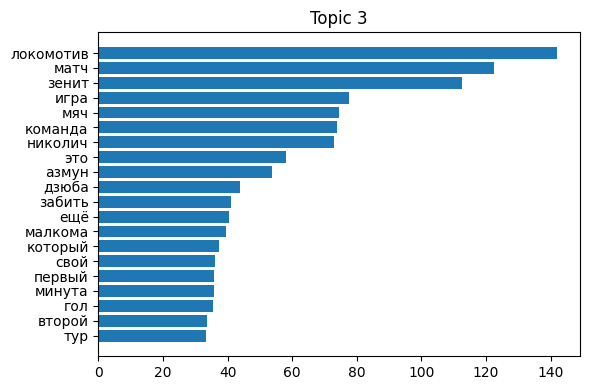

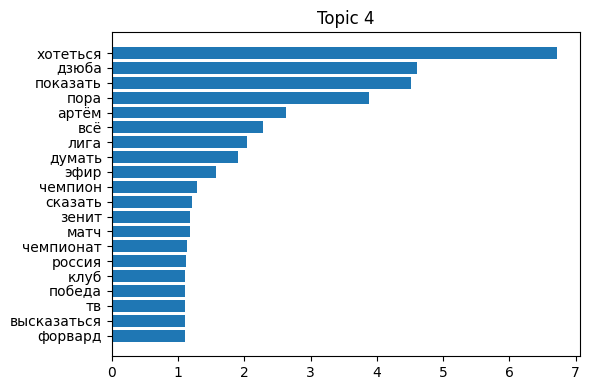

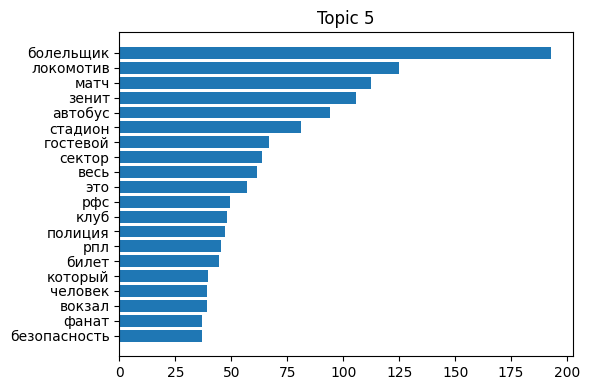

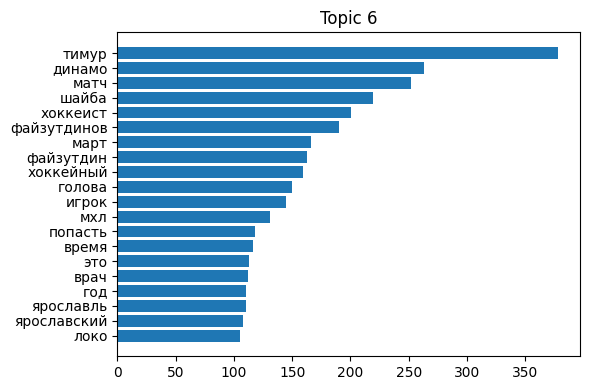

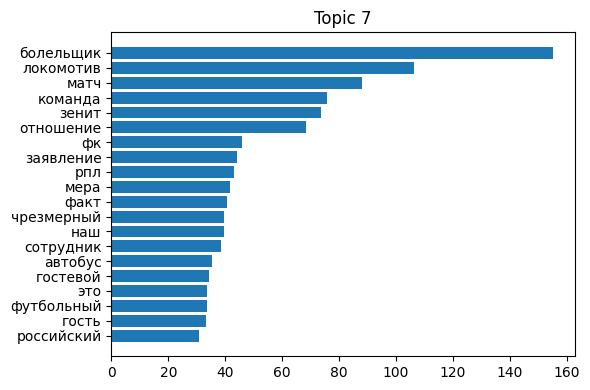

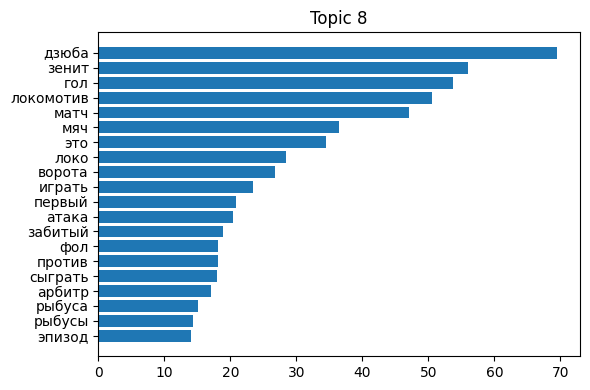

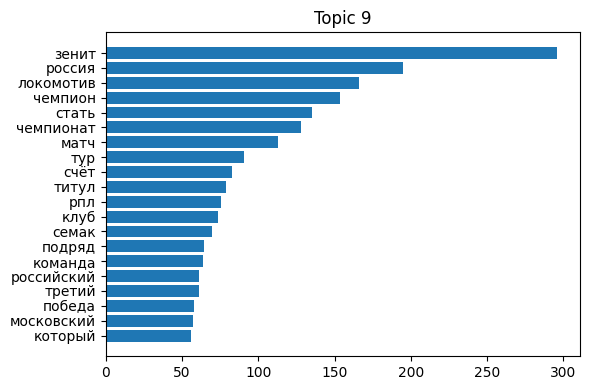

NMF Model:


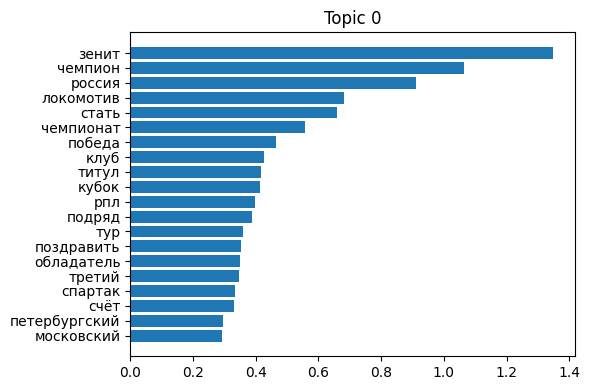

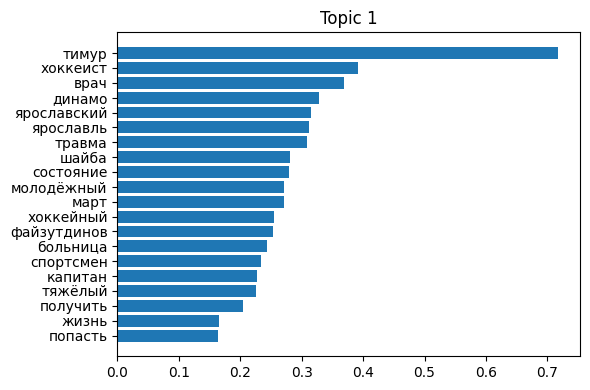

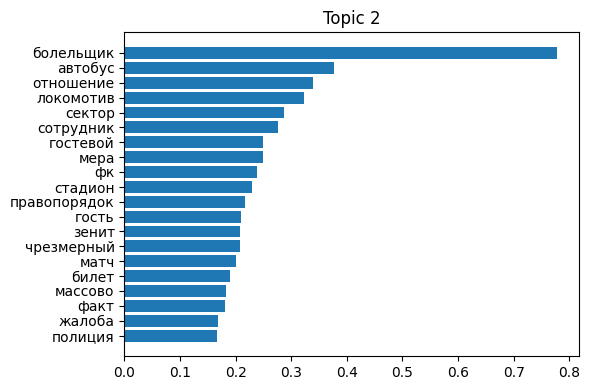

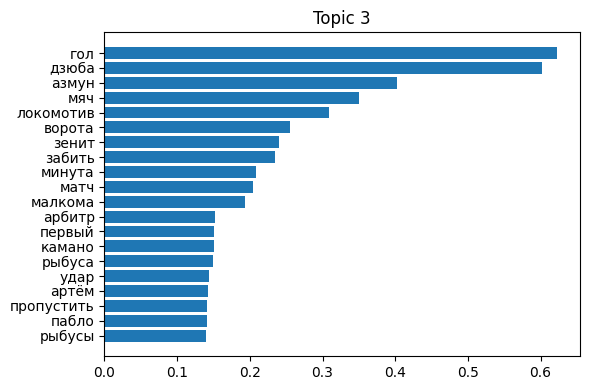

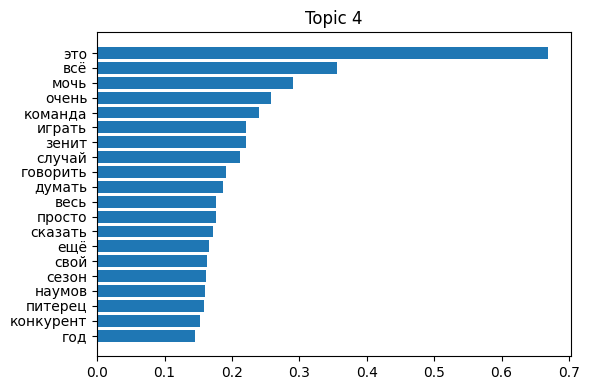

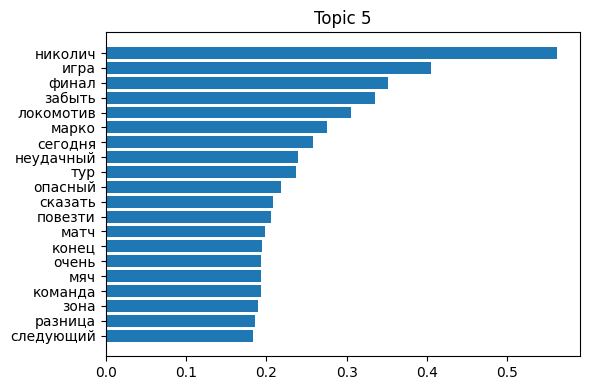

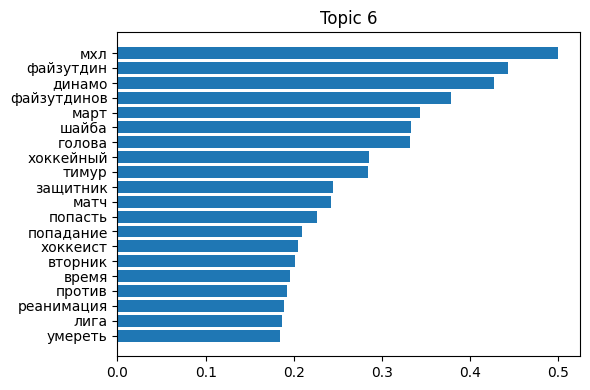

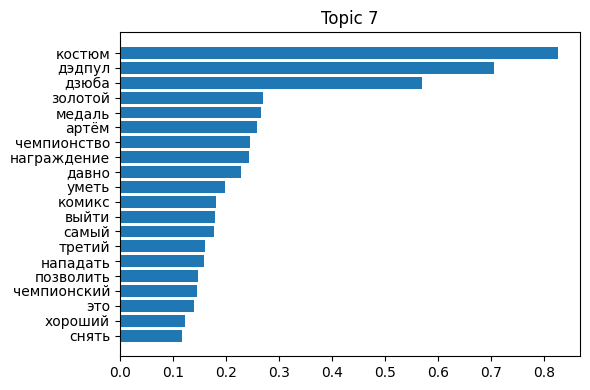

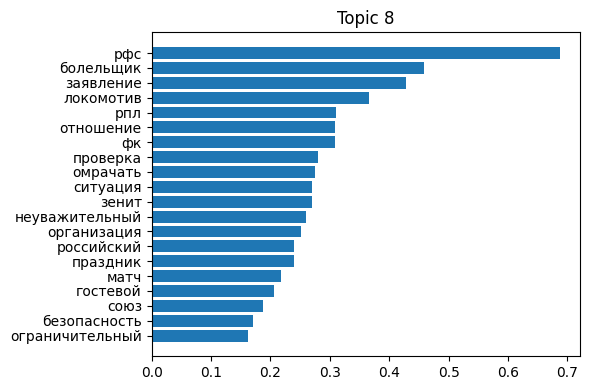

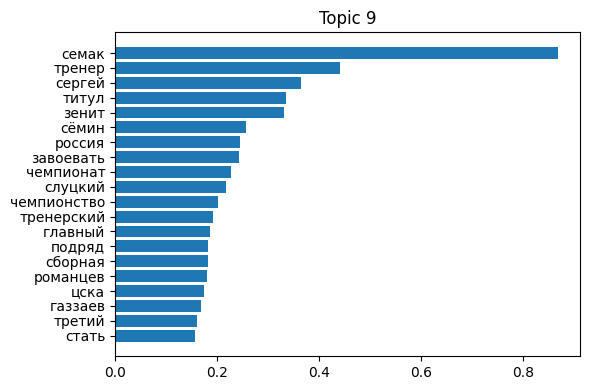

In [10]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import os
import glob
import pymorphy3

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('russian'))

# Загрузка коллекции текстовых документов

# Предобработка текстовых данных
def preprocess_text(text):
    tokens = word_tokenize(text) # получение токенов
    morph = pymorphy3.MorphAnalyzer()    
    tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalnum() and not token.isdigit()]
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens) 

# Функция для визуализации топ-слов каждой темы
def plot_top_words(model, feature_names, n_top_words):
    num_topics = len(model.components_)
    for topic_idx, topic in enumerate(model.components_):
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        ax.barh(range(n_top_words), topic[top_words_idx], align='center')
        ax.set_yticks(range(n_top_words))
        ax.set_yticklabels(top_words)
        ax.invert_yaxis()
        ax.set_title(f'Topic {topic_idx}')
        plt.tight_layout()
        plt.show()

# Параметры моделирования
n_features = 1000
n_topics = 10
n_top_words = 20

# Путь к папке с коллекцией текстовых документов
folder_path = 'sport_2021'

# Загрузка коллекции текстовых документов
documents = []
for file_path in glob.glob(os.path.join(folder_path, '*.txt')):
    with open(file_path, 'r', encoding='utf-8') as file:
        documents.append(file.read())

# Предобработка текстов
documents = [preprocess_text(doc) if doc.strip() else "" for doc in documents]

# Удаление пустых документов
documents = [doc for doc in documents if doc]

# Создание пайплайна для моделирования
pipeline_lda = Pipeline([
    ('vectorizer', CountVectorizer(max_features=n_features)),
    ('lda', LatentDirichletAllocation(n_components=n_topics, random_state=42)),
])

pipeline_nmf = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=n_features)),
    ('nmf', NMF(n_components=n_topics, random_state=42)),
])

# Обучение моделей
lda_model = pipeline_lda.fit(documents)
nmf_model = pipeline_nmf.fit(documents)

# Получение списка признаков
vectorizer = pipeline_lda.named_steps['vectorizer']
tfidf_vectorizer = pipeline_nmf.named_steps['vectorizer']
feature_names_lda = vectorizer.get_feature_names_out()
feature_names_nmf = tfidf_vectorizer.get_feature_names_out()

# Визуализация топ-слов для каждой темы
print("LDA Model:")
plot_top_words(lda_model.named_steps['lda'], feature_names_lda, n_top_words)

print("NMF Model:")
plot_top_words(nmf_model.named_steps['nmf'], feature_names_nmf, n_top_words)
